### 回归 分类概率-融合：###

In [1]:
## 1）简单加权平均，结果直接融合

## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表第模型的真实值
y_test_true = [1, 3, 2, 6] 


In [3]:
import numpy as np
import pandas as pd

## 定义结果的加权平均函数
def Weighted_method(test_pre1,test_pre2,test_pre3,w=[1/3,1/3,1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result

In [5]:
from sklearn import metrics
# 各模型的预测结果计算MAE
print('Pred1 MAE:',metrics.mean_absolute_error(y_test_true, test_pre1))
print('Pred2 MAE:',metrics.mean_absolute_error(y_test_true, test_pre2))
print('Pred3 MAE:',metrics.mean_absolute_error(y_test_true, test_pre3))

Pred1 MAE: 0.1750000000000001
Pred2 MAE: 0.07499999999999993
Pred3 MAE: 0.10000000000000009


In [5]:
## 根据加权计算MAE
w = [0.3,0.4,0.3] # 定义比重权值
Weighted_pre = Weighted_method(test_pre1,test_pre2,test_pre3,w)
print('Weighted_pre MAE:',metrics.mean_absolute_error(y_test_true, Weighted_pre))

Weighted_pre MAE: 0.05750000000000027


In [6]:
## 定义结果的加权平均函数
def Mean_method(test_pre1,test_pre2,test_pre3):
    Mean_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).mean(axis=1)
    return Mean_result

In [7]:
Mean_pre = Mean_method(test_pre1,test_pre2,test_pre3)
print('Mean_pre MAE:',metrics.mean_absolute_error(y_test_true, Mean_pre))

Mean_pre MAE: 0.06666666666666693


In [8]:
## 定义结果的加权平均函数
def Median_method(test_pre1,test_pre2,test_pre3):
    Median_result = pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).median(axis=1)
    return Median_result

In [9]:
Median_pre = Median_method(test_pre1,test_pre2,test_pre3)
print('Median_pre MAE:',metrics.mean_absolute_error(y_test_true, Median_pre))

Median_pre MAE: 0.07500000000000007


In [1]:
# Stacking融合(回归)：

from sklearn import linear_model

def Stacking_method(train_reg1,train_reg2,train_reg3,y_train_true,test_pre1,test_pre2,test_pre3,model_L2= linear_model.LinearRegression()):
    model_L2.fit(pd.concat([pd.Series(train_reg1),pd.Series(train_reg2),pd.Series(train_reg3)],axis=1).values,y_train_true)
    Stacking_result = model_L2.predict(pd.concat([pd.Series(test_pre1),pd.Series(test_pre2),pd.Series(test_pre3)],axis=1).values)
    return Stacking_result

In [6]:
## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
train_reg1 = [3.2, 8.2, 9.1, 5.2]
train_reg2 = [2.9, 8.1, 9.0, 4.9]
train_reg3 = [3.1, 7.9, 9.2, 5.0]
# y_test_true 代表第模型的真实值
y_train_true = [3, 8, 9, 5] 

test_pre1 = [1.2, 3.2, 2.1, 6.2]
test_pre2 = [0.9, 3.1, 2.0, 5.9]
test_pre3 = [1.1, 2.9, 2.2, 6.0]

# y_test_true 代表第模型的真实值
y_test_true = [1, 3, 2, 6] 

model_L2= linear_model.LinearRegression()
Stacking_pre = Stacking_method(train_reg1,train_reg2,train_reg3,y_train_true,
                               test_pre1,test_pre2,test_pre3,model_L2)
print('Stacking_pre MAE:',metrics.mean_absolute_error(y_test_true, Stacking_pre))



Stacking_pre MAE: 0.042134831460675204


#### 可以发现模型结果相对于之前有进一步的提升，这是我们需要注意的一点是，对于第二层Stacking的模型不宜选取的过于复杂，这样会导致模型在训练集上过拟合，从而使得在测试集上并不能达到很好的效果。####

In [ ]:
#分类模型融合：

#对于分类，同样的可以使用融合方法，比如简单投票，Stacking...

In [7]:
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#### 1）Voting投票机制：Voting即投票机制，分为软投票和硬投票两种，其原理采用少数服从多数的思想。 ####

In [8]:
'''
硬投票：对多个模型直接进行投票，不区分模型结果的相对重要度，最终投票数最多的类为最终被预测的类。
'''
iris = datasets.load_iris()

x=iris.data
y=iris.target
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.7,
                     colsample_bytree=0.6, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63,oob_score=True)
clf3 = SVC(C=0.1)

# 硬投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.03) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [SVM]
Accuracy: 0.91 (+/- 0.04) [Ensemble]


In [9]:
'''
软投票：和硬投票原理相同，增加了设置权重的功能，可以为不同模型设置不同权重，进而区别模型不同的重要度。
'''
x=iris.data
y=iris.target
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

clf1 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=3, min_child_weight=2, subsample=0.8,
                     colsample_bytree=0.8, objective='binary:logistic')
clf2 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
                              min_samples_leaf=63,oob_score=True)
clf3 = SVC(C=0.1, probability=True)

# 软投票
eclf = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 1])
clf1.fit(x_train, y_train)

for clf, label in zip([clf1, clf2, clf3, eclf], ['XGBBoosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.02) [XGBBoosting]
Accuracy: 0.33 (+/- 0.00) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [SVM]
Accuracy: 0.96 (+/- 0.02) [Ensemble]


#### 2）分类的Stacking\Blending融合：stacking是一种分层模型集成框架。以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而得到完整的stacking模型, stacking两层模型都使用了全部的训练数据。 ####

In [10]:
'''
5-Fold Stacking
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
import pandas as pd
#创建训练的数据集
data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]

#模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

#5折stacking
n_splits = 5
skf = StratifiedKFold(n_splits)
skf = skf.split(X, y)

for j, clf in enumerate(clfs):
    #依次训练各个单模型
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    for i, (train, test) in enumerate(skf):
        #5-Fold交叉训练，使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
    #对于测试集，直接用这k个模型的预测值均值作为新的特征。
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_blend_test[:, j]))

clf = LogisticRegression(solver='lbfgs')
clf.fit(dataset_blend_train, y)
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]

print("Val auc Score of Stacking: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 0.500000
val auc Score: 0.500000
val auc Score: 0.500000
val auc Score: 0.500000
Val auc Score of Stacking: 1.000000


#### Blending，其实和Stacking是一种类似的多层模型融合的形式 ####

其主要思路是把原始的训练集先分成两部分，比如70%的数据作为新的训练集，剩下30%的数据作为测试集。

在第一层，我们在这70%的数据上训练多个模型，然后去预测那30%数据的label，同时也预测test集的label。

在第二层，我们就直接用这30%数据在第一层预测的结果做为新特征继续训练，然后用test集第一层预测的label做特征，用第二层训练的模型做进一步预测

其优点在于：

1.比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）

2.避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集

缺点在于：

1.使用了很少的数据（第二阶段的blender只使用training set10%的量）

2.blender可能会过拟合

3.stacking使用多次的交叉验证会比较稳健 '''

In [11]:
'''
Blending
'''
 
#创建训练的数据集
data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]
 
#模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        #ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=2020)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))

#融合使用的模型
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
Val auc Score of Blending: 1.000000


Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [Stacking Classifier]


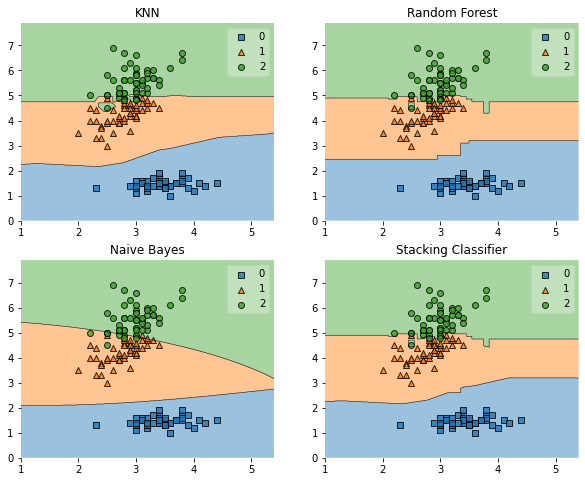

In [12]:
##3）分类的Stacking融合(利用mlxtend)：

!pip install mlxtend

import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

In [ ]:
可以发现 基模型 用 'KNN', 'Random Forest', 'Naive Bayes' 然后再这基础上 次级模型加一个 'LogisticRegression'，模型测试效果有着很好的提升。

In [13]:
#一些其它方法
#将特征放进模型中预测，并将预测结果变换并作为新的特征加入原有特征中再经过模型预测结果 （Stacking变化）
#（可以反复预测多次将结果加入最后的特征中）

def Ensemble_add_feature(train,test,target,clfs):
    
    # n_flods = 5
    # skf = list(StratifiedKFold(y, n_folds=n_flods))

    train_ = np.zeros((train.shape[0],len(clfs*2)))
    test_ = np.zeros((test.shape[0],len(clfs*2)))

    for j,clf in enumerate(clfs):
        '''依次训练各个单模型'''
        # print(j, clf)
        '''使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。'''
        # X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]

        clf.fit(train,target)
        y_train = clf.predict(train)
        y_test = clf.predict(test)

        ## 新特征生成
        train_[:,j*2] = y_train**2
        test_[:,j*2] = y_test**2
        train_[:, j+1] = np.exp(y_train)
        test_[:, j+1] = np.exp(y_test)
        # print("val auc Score: %f" % r2_score(y_predict, dataset_d2[:, j]))
        print('Method ',j)
    
    train_ = pd.DataFrame(train_)
    test_ = pd.DataFrame(test_)
    return train_,test_


In [14]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

data_0 = iris.data
data = data_0[:100,:]

target_0 = iris.target
target = target_0[:100]

x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.3)
x_train = pd.DataFrame(x_train) ; x_test = pd.DataFrame(x_test)

#模型融合中使用到的各个单模型
clfs = [LogisticRegression(),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

New_train,New_test = Ensemble_add_feature(x_train,x_test,y_train,clfs)

clf = LogisticRegression()
# clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(New_train, y_train)
y_emb = clf.predict_proba(New_test)[:, 1]

print("Val auc Score of stacking: %f" % (roc_auc_score(y_test, y_emb)))

Method  0
Method  1
Method  2
Method  3
Method  4
Val auc Score of stacking: 1.000000


#### 本赛题示例 ####

In [15]:
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

import itertools
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
# from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
# from mlxtend.plotting import plot_learning_curves
# from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
## 数据读取


Train_data = pd.read_csv('./data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('./data/used_car_testB_20200421.csv', sep=' ')

print(Train_data.shape)
print(TestA_data.shape)

(150000, 31)
(50000, 30)


In [17]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [18]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [19]:
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','price']]

In [20]:
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 26)
X test shape: (50000, 26)


In [21]:
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [22]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876438
_var 56279605.94272992


In [23]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [24]:
def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_ridge(x_train,y_train):
    reg_model = linear_model.Ridge(alpha=0.8)#alphas=range(1,100,5)
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_lasso(x_train,y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [25]:
# XGBoost的五折交叉回归验证实现

## xgb
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) # ,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

[09:50:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:53:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train mae: 594.4890495346745
Val mae 694.5823127983205


In [27]:
#划分数据集，并用多种方法训练和预测

## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

## Train and Predict
print('Predict LR...')
model_lr = build_model_lr(x_train,y_train)
val_lr = model_lr.predict(x_val)
subA_lr = model_lr.predict(X_test)

print('Predict Ridge...')
model_ridge = build_model_ridge(x_train,y_train)
val_ridge = model_ridge.predict(x_val)
subA_ridge = model_ridge.predict(X_test)

print('Predict Lasso...')
model_lasso = build_model_lasso(x_train,y_train)
val_lasso = model_lasso.predict(x_val)
subA_lasso = model_lasso.predict(X_test)

print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train,y_train)
val_gbdt = model_gbdt.predict(x_val)
subA_gbdt = model_gbdt.predict(X_test)

Predict LR...
Predict Ridge...
Predict Lasso...
Predict GBDT...
{'learning_rate': 0.2}


In [28]:
# 一般比赛中效果最为显著的两种方法

print('predict XGB...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
subA_xgb = model_xgb.predict(X_test)

print('predict lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
subA_lgb = model_lgb.predict(X_test)

predict XGB...
[10:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
predict lgb...


In [29]:
print('Sta inf of lgb:')
Sta_inf(subA_lgb)

Sta inf of lgb:
_min -200.26439750643075
_max: 90023.76463744824
_mean 5910.283884310833
_ptp 90224.02903495467
_std 7342.135740261372
_var 53906957.22842341


In [30]:
# 加权融合

def Weighted_method(test_pre1,test_pre2,test_pre3,w=[1/3,1/3,1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result

## Init the Weight
w = [0.3,0.4,0.3]

## 测试验证集准确度
val_pre = Weighted_method(val_lgb,val_xgb,val_gbdt,w)
MAE_Weighted = mean_absolute_error(y_val,val_pre)
print('MAE of Weighted of val:',MAE_Weighted)

## 预测数据部分
subA = Weighted_method(subA_lgb,subA_xgb,subA_gbdt,w)
print('Sta inf:')
Sta_inf(subA)
## 生成提交文件
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subA
sub.to_csv('./sub_Weighted.csv',index=False)

MAE of Weighted of val: 721.3695327391271
Sta inf:
_min -52.09900168247665
_max: 90618.27724080338
_mean 5910.884971852102
_ptp 90670.37624248586
_std 7320.015724491596
_var 53582630.20680423


In [31]:
## 与简单的LR（线性回归）进行对比
val_lr_pred = model_lr.predict(x_val)
MAE_lr = mean_absolute_error(y_val,val_lr_pred)
print('MAE of lr:',MAE_lr)

MAE of lr: 2592.0723908589257


In [32]:
# Stacking融合

## Stacking

## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Stack_X_train = pd.DataFrame()
Stack_X_train['Method_1'] = train_lgb_pred
Stack_X_train['Method_2'] = train_xgb_pred
Stack_X_train['Method_3'] = train_gbdt_pred

Stack_X_val = pd.DataFrame()
Stack_X_val['Method_1'] = val_lgb
Stack_X_val['Method_2'] = val_xgb
Stack_X_val['Method_3'] = val_gbdt

Stack_X_test = pd.DataFrame()
Stack_X_test['Method_1'] = subA_lgb
Stack_X_test['Method_2'] = subA_xgb
Stack_X_test['Method_3'] = subA_gbdt

In [33]:
## level2-method 
model_lr_Stacking = build_model_lr(Stack_X_train,y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Stack_X_train)
print('MAE of Stacking-LR:',mean_absolute_error(y_train,train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Stack_X_val)
print('MAE of Stacking-LR:',mean_absolute_error(y_val,val_pre_Stacking))

## 预测集
print('Predict Stacking-LR...')
subA_Stacking = model_lr_Stacking.predict(Stack_X_test)

MAE of Stacking-LR: 635.0208068447632
MAE of Stacking-LR: 713.8166458581238
Predict Stacking-LR...


In [34]:
subA_Stacking[subA_Stacking<10]=10  ## 去除过小的预测值

sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subA_Stacking
sub.to_csv('./sub_Stacking.csv',index=False)

In [35]:
print('Sta inf:')
Sta_inf(subA_Stacking)

Sta inf:
_min 10.0
_max: 90920.4746348249
_mean 5911.663185988326
_ptp 90910.4746348249
_std 7375.982910177883
_var 54405123.89123619
